In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

In [2]:
def show_image(image, title=''):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def draw_rectangle(image, start_point, end_point, color=(0, 255, 0), thickness=3):
    image = image.copy()
    return cv2.rectangle(image, start_point, end_point, color, thickness)

(2560, 2560, 3)


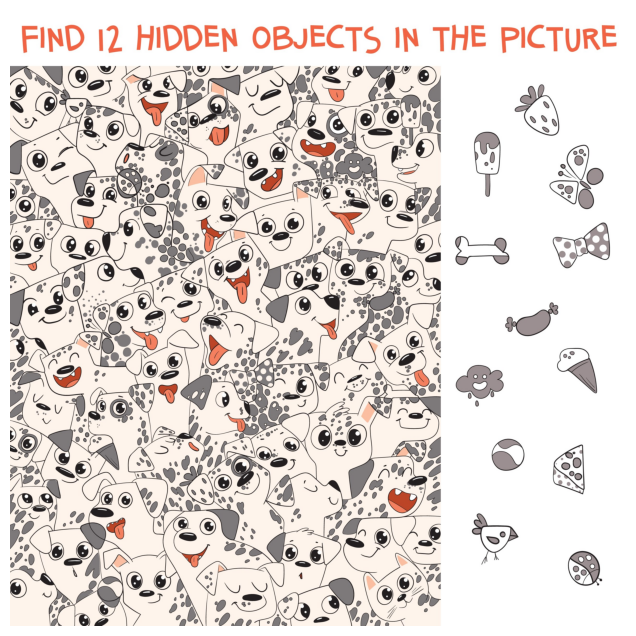

In [3]:
IMAGE_PATH = 'Midterm-ImageSet/Finding/2.jpg'
image = cv2.imread(IMAGE_PATH)
print(image.shape)
show_image(image)

### Chuẩn bị ảnh đầu vào và các mẫu cần được tìm kiếm

In [4]:
input_image = cv2.imread(IMAGE_PATH)[230:, :1790]
template_image = cv2.imread(IMAGE_PATH)[230:, 1790:]

print(f"Input image shape: {input_image.shape}")
print(f"Template image shape: {template_image.shape}")

Input image shape: (2330, 1790, 3)
Template image shape: (2330, 770, 3)


Vị trí các mẫu

In [5]:
objects_position = [
    # (x, y, w, h)
    (300, 70, 200, 230),
    (130, 270, 130, 280),
    (440, 330, 240, 270), 
    (50, 700, 240, 140),
    (450, 650, 260, 200),
    (260, 980, 230, 150),
    (50, 1240, 210, 180),
    (480, 1160, 180, 210),
    (210, 1540, 140, 150),
    (460, 1570, 150, 220),
    (120, 1850, 210, 230),
    (520, 2010, 160, 160)
]

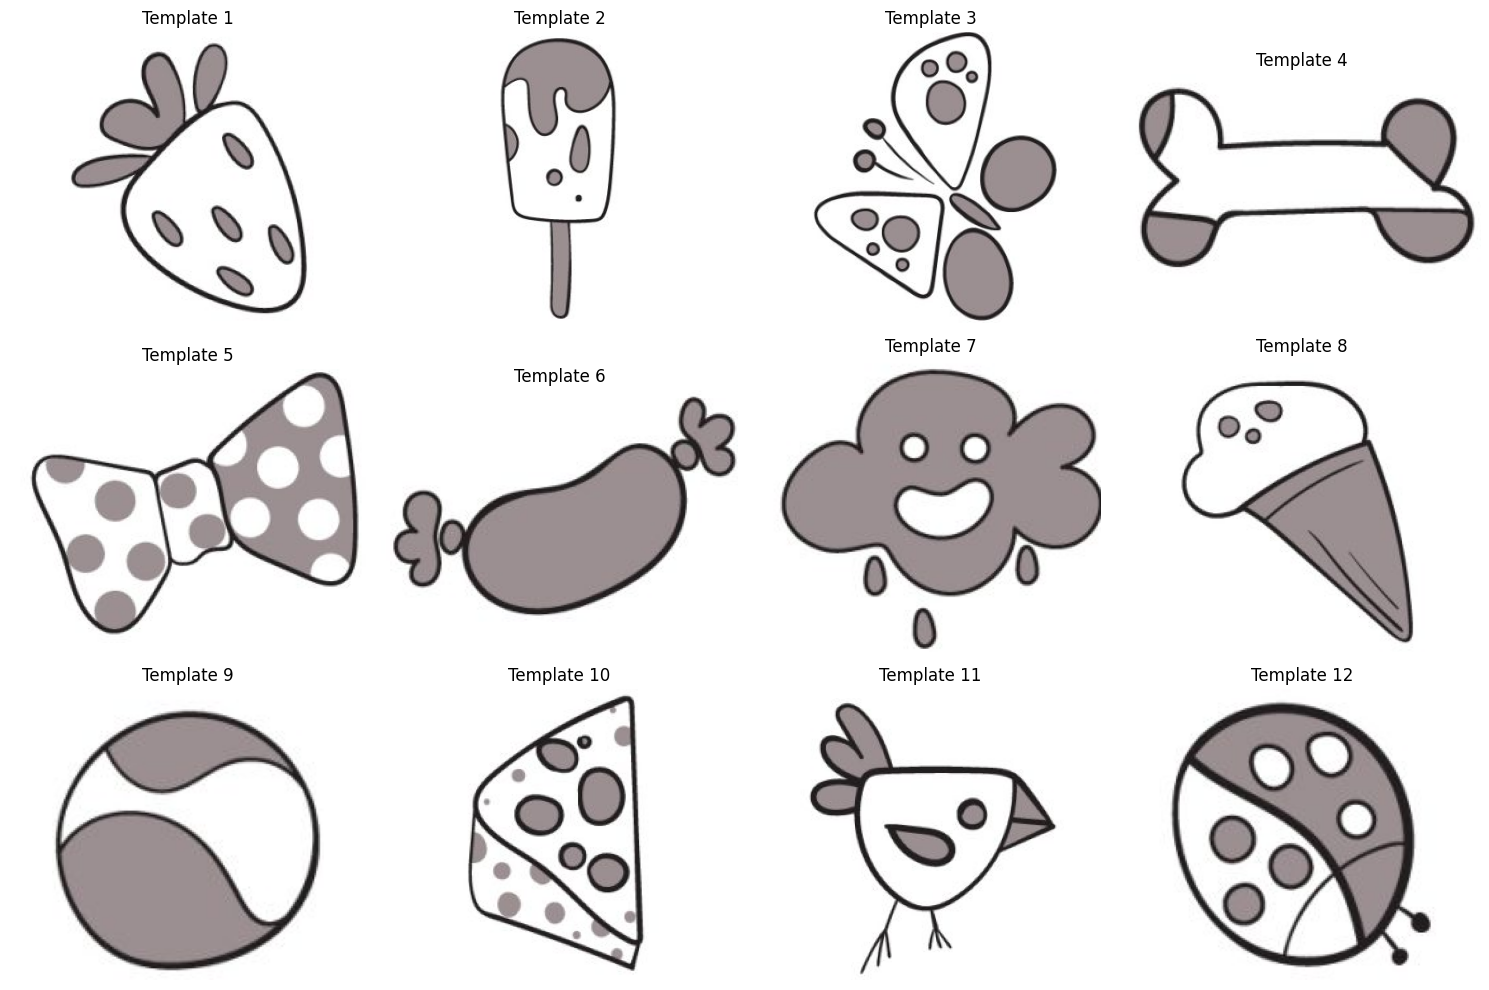

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for i, (x, y, w, h) in enumerate(objects_position):
    sample = template_image[y: y+h, x:x+w]
    axes[i].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Template {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Thực hiện template matching trên ảnh xám

In [7]:
input_gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
template_gray_image = cv2.cvtColor(template_image, cv2.COLOR_BGR2GRAY)

#### thử nghiệm trên template đầu tiên, sử dụng method cv2.TM_SQDIFF_NORMED, giá trị càng nhỏ thì càng khớp

In [8]:
x, y, w, h = objects_position[0]
sample = template_gray_image[y: y+h, x:x+w]
print(f"Sample shape: {sample.shape}")

Sample shape: (230, 200)


(2101, 1591)


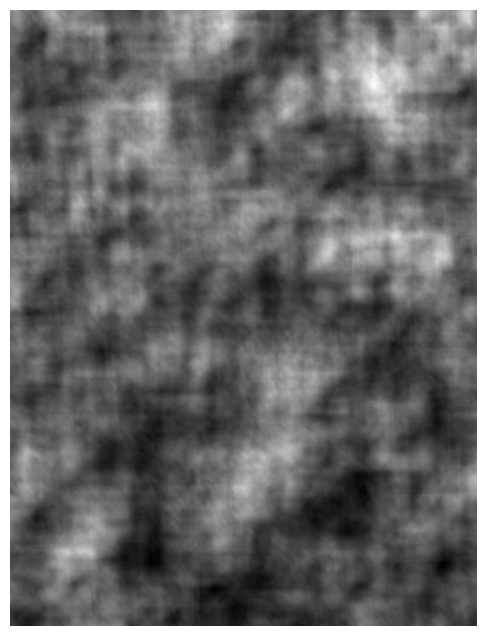

In [9]:
matching_result = cv2.matchTemplate(input_gray_image, sample, cv2.TM_SQDIFF_NORMED)
print(matching_result.shape)
plt.imshow(matching_result, cmap='gray')
plt.axis('off');

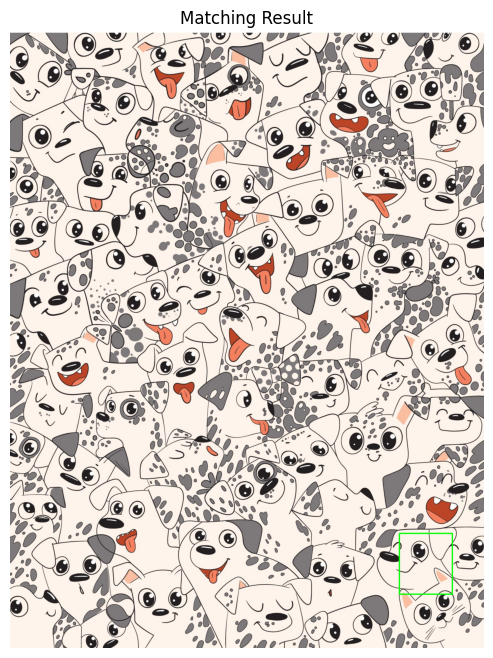

In [10]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matching_result)
show_image(
    draw_rectangle(input_image, min_loc, (min_loc[0] + sample.shape[1], min_loc[1] + sample.shape[0])),
    title='Matching Result'
)

#### thử nhiều kích cỡ khác nhau của template

In [11]:
def match_template(
    input_image, template_image, position, 
    scale=1.0, method=cv2.TM_CCOEFF_NORMED
):
    x, y, w, h = position
    sample = template_image[y: y+h, x:x+w]
    resized_sample = cv2.resize(sample, None, fx=scale, fy=scale)
    matching_result = cv2.matchTemplate(input_image, resized_sample, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matching_result)

    if method == cv2.TM_SQDIFF_NORMED or method == cv2.TM_SQDIFF:
        return matching_result, min_loc, min_val
    else:
        return matching_result, max_loc, max_val

def match_template_multi_scale(
    input_image, template_image, position,
    min_scale, max_scale, num_scales,
    method=cv2.TM_CCOEFF_NORMED,
):
    x, y, w, h = position
    sample = template_image[y: y+h, x:x+w]

    scales = np.linspace(min_scale, max_scale, num_scales)
    positions = []
    scores = []
    for scale in scales:
        resized_sample = cv2.resize(sample, None, fx=scale, fy=scale)
        matching_result = cv2.matchTemplate(input_image, resized_sample, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matching_result)
        if method == cv2.TM_SQDIFF_NORMED or method == cv2.TM_SQDIFF:
            best_loc = min_loc
            best_val = min_val
        else:
            best_loc = max_loc
            best_val = max_val
        positions.append([best_loc, (best_loc[0] + resized_sample.shape[1], best_loc[1] + resized_sample.shape[0])])
        scores.append(best_val)
    return positions, scores

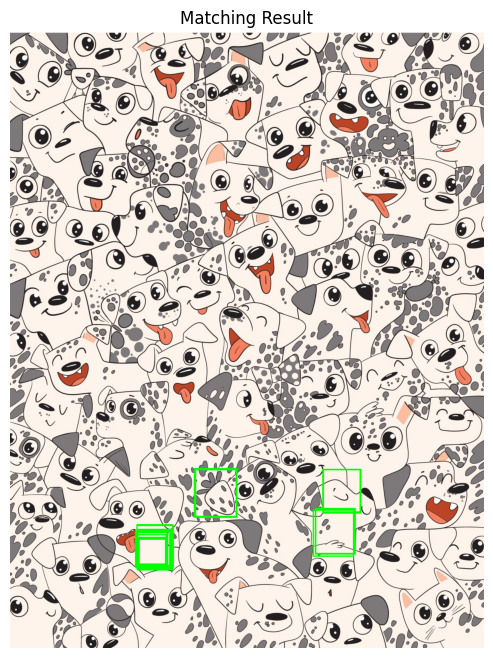

In [12]:
positions, scores = match_template_multi_scale(
    input_gray_image, template_gray_image, objects_position[0],
    min_scale=0.5, max_scale=0.8, num_scales=30,
    method=cv2.TM_SQDIFF_NORMED
)
scales = np.linspace(0.5, 0.8, 30)

result_image = input_image.copy()
for (start, end) in positions:
    result_image = draw_rectangle(result_image, start, end, color=(0, 255, 0), thickness=3)

show_image(result_image, title='Matching Result')

hiể n thị kết quả tốt nhất

Best score: 0.07116673141717911
Best scale: 0.7793103448275862


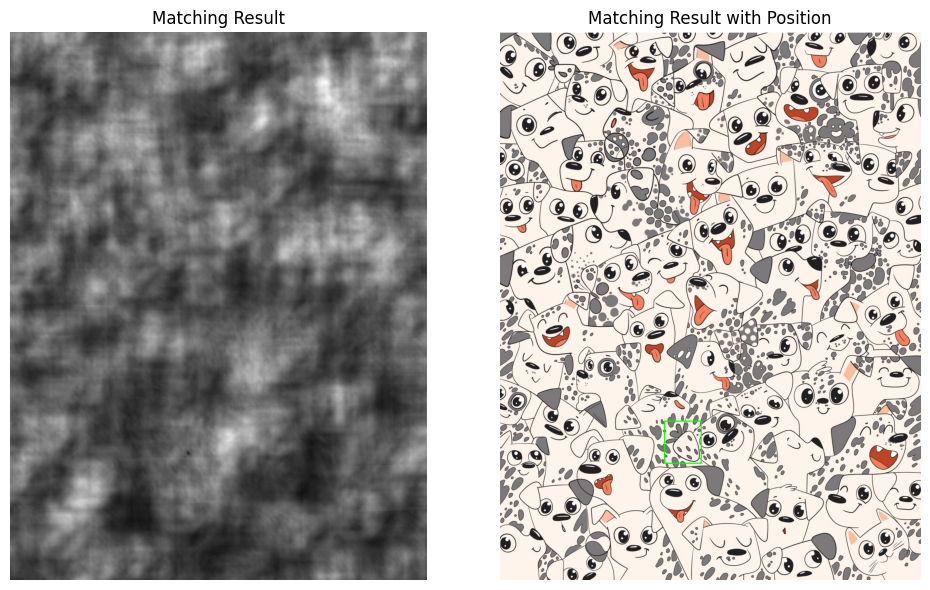

In [13]:
best_position = positions[np.argmin(scores)]
best_scale = scales[np.argmin(scores)]
print(f"Best score: {min(scores)}")
print(f"Best scale: {best_scale}")

matching_result, best_loc, best_val = match_template(
    input_gray_image, template_gray_image, objects_position[0],
    scale=best_scale,
    method=cv2.TM_SQDIFF_NORMED
)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(matching_result, cmap='gray')
plt.title('Matching Result')
plt.axis('off')
result_image = draw_rectangle(input_image, best_position[0], best_position[1], color=(0, 255, 0), thickness=3)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Matching Result with Position')
plt.axis('off')
plt.tight_layout()
plt.show()

#### sử dụng method cv2.TM_CCORR_NORMED

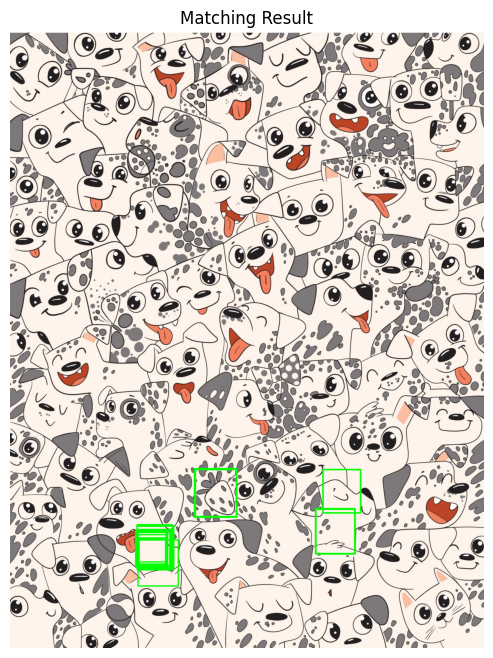

In [14]:
positions, scores = match_template_multi_scale(
    input_gray_image, template_gray_image, objects_position[0],
    min_scale=0.5, max_scale=0.8, num_scales=30,
    method=cv2.TM_CCORR_NORMED
)
scales = np.linspace(0.5, 0.8, 30)

result_image = input_image.copy()
for (start, end) in positions:
    result_image = draw_rectangle(result_image, start, end, color=(0, 255, 0), thickness=3)

show_image(result_image, title='Matching Result')

Best score: 0.9706114530563354
Best scale: 0.7793103448275862


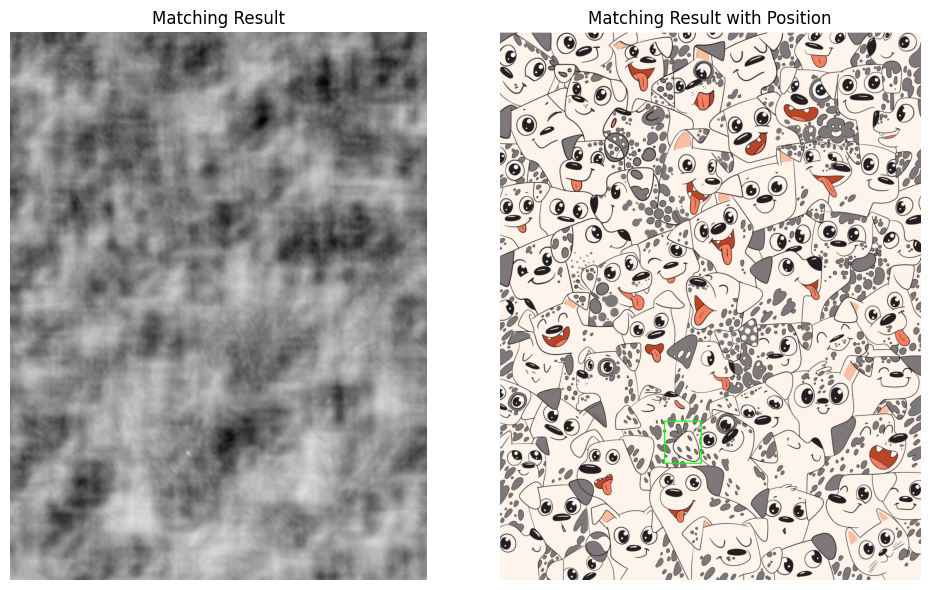

In [15]:
best_position = positions[np.argmax(scores)]
best_scale = scales[np.argmax(scores)]
print(f"Best score: {max(scores)}")
print(f"Best scale: {best_scale}")

matching_result, best_loc, best_val = match_template(
    input_gray_image, template_gray_image, objects_position[0],
    scale=best_scale,
    method=cv2.TM_CCORR_NORMED
)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(matching_result, cmap='gray')
plt.title('Matching Result')
plt.axis('off')
result_image = draw_rectangle(input_image, best_position[0], best_position[1], color=(0, 255, 0), thickness=3)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Matching Result with Position')
plt.axis('off')
plt.tight_layout()
plt.show()

#### sử dụng method cv2.TM_CCOEFF_NORMED

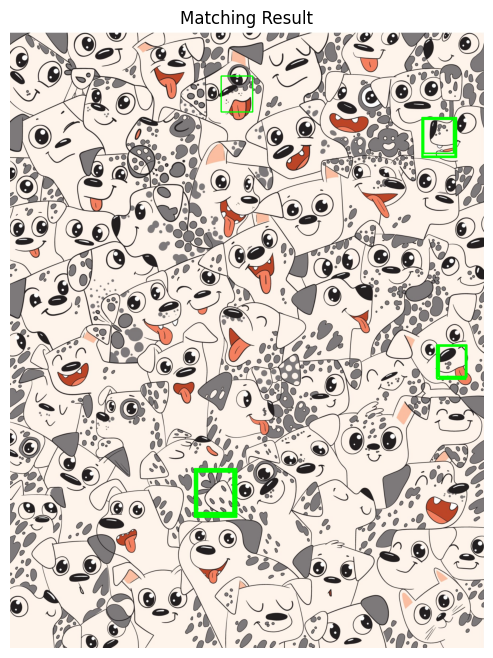

In [16]:
positions, scores = match_template_multi_scale(
    input_gray_image, template_gray_image, objects_position[0],
    min_scale=0.5, max_scale=0.8, num_scales=30,
    method=cv2.TM_CCOEFF_NORMED
)
scales = np.linspace(0.5, 0.8, 30)

result_image = input_image.copy()
for (start, end) in positions:
    result_image = draw_rectangle(result_image, start, end, color=(0, 255, 0), thickness=3)

show_image(result_image, title='Matching Result')

Best score: 0.7316612601280212
Best scale: 0.7793103448275862


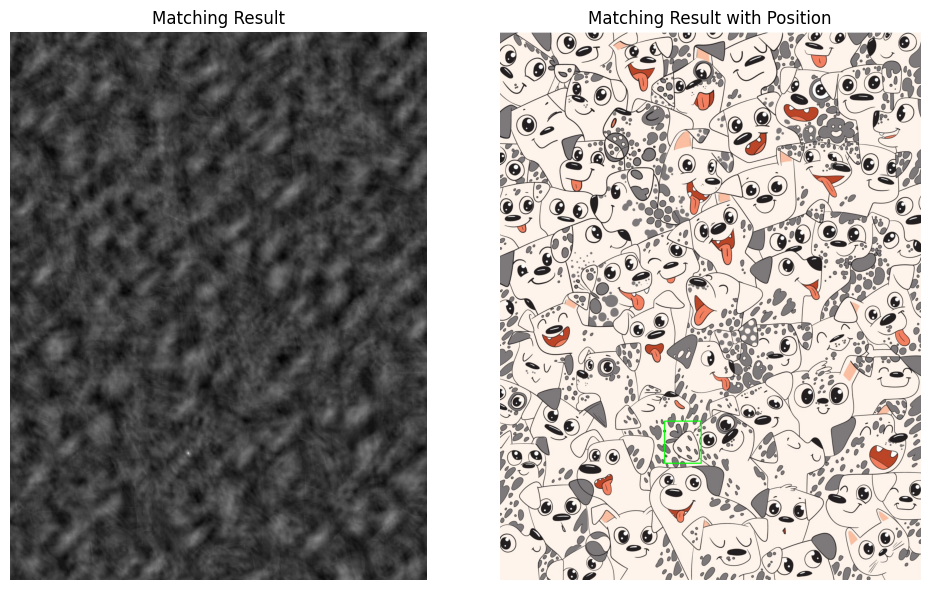

In [17]:
best_position = positions[np.argmax(scores)]
best_scale = scales[np.argmax(scores)]
print(f"Best score: {max(scores)}")
print(f"Best scale: {best_scale}")

matching_result, best_loc, best_val = match_template(
    input_gray_image, template_gray_image, objects_position[0],
    scale=best_scale,
    method=cv2.TM_CCOEFF_NORMED
)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(matching_result, cmap='gray')
plt.title('Matching Result')
plt.axis('off')
result_image = draw_rectangle(input_image, best_position[0], best_position[1], color=(0, 255, 0), thickness=3)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Matching Result with Position')
plt.axis('off')
plt.tight_layout()
plt.show()

#### thực hiện template matching trên tất cả các mẫu

lần lượt tìm tất cả các mẫu, lưu lại vị trí có độ khớp tốt nhất đối với từng mẫu

In [18]:
best_positions = []
best_scores = []
for i, (position) in enumerate(objects_position):
    positions, scores = match_template_multi_scale(
        input_gray_image, template_gray_image, position,
        min_scale=0.5, max_scale=0.8, num_scales=30,
        method=cv2.TM_CCOEFF_NORMED
    )
    best_positions.append(positions[np.argmax(scores)])
    best_scores.append(max(scores))
    print(f"Best score for object {i+1}: {max(scores):.4f}")

Best score for object 1: 0.7317
Best score for object 2: 0.7159
Best score for object 3: 0.7350
Best score for object 4: 0.7696
Best score for object 5: 0.6441
Best score for object 6: 0.6957
Best score for object 7: 0.6477
Best score for object 8: 0.8759
Best score for object 9: 0.8057
Best score for object 10: 0.7660
Best score for object 11: 0.6387
Best score for object 12: 0.6865


hiển thị kết quả

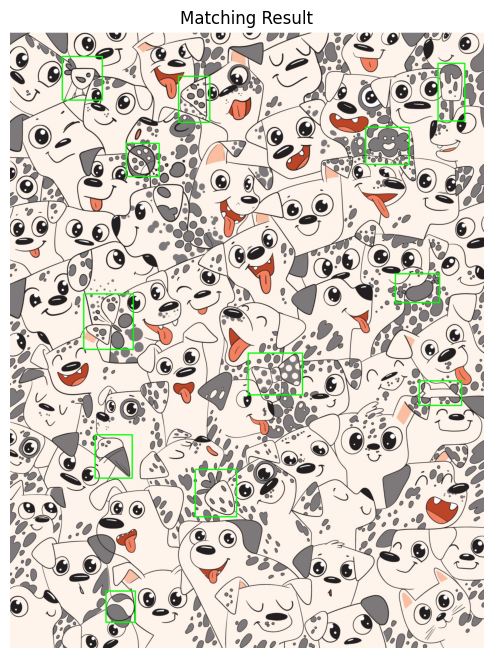

In [19]:
result_image = input_image.copy()
for (start, end) in best_positions:
    result_image = draw_rectangle(result_image, start, end, color=(0, 255, 0), thickness=3)
show_image(result_image, title='Matching Result')

### Thực hiện template matching trên ảnh áp dụng thuật toán phát hiện cạnh

In [20]:
input_edge_image = cv2.Canny(input_image, 100, 200)
template_edge_image = cv2.Canny(template_image, 100, 200)

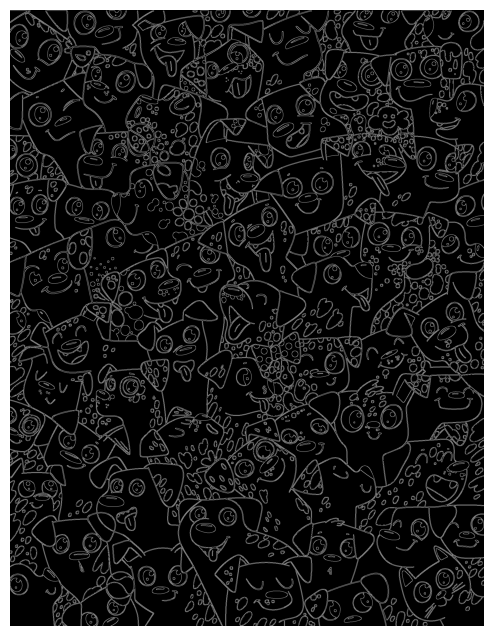

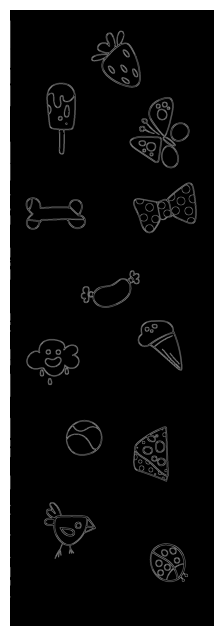

In [21]:
show_image(input_edge_image)
show_image(template_edge_image)

In [22]:
best_positions = []
best_scores = []
for i, (position) in enumerate(objects_position):
    positions, scores = match_template_multi_scale(
        input_edge_image, template_edge_image, position,
        min_scale=0.5, max_scale=0.8, num_scales=30,
        method=cv2.TM_CCOEFF_NORMED
    )
    best_positions.append(positions[np.argmax(scores)])
    best_scores.append(max(scores))
    print(f"Best score for object {i+1}: {max(scores)}")

Best score for object 1: 0.4711008667945862
Best score for object 2: 0.46206921339035034
Best score for object 3: 0.553767740726471
Best score for object 4: 0.559360921382904
Best score for object 5: 0.5021703243255615
Best score for object 6: 0.46900030970573425
Best score for object 7: 0.40972480177879333
Best score for object 8: 0.54686439037323
Best score for object 9: 0.5474216341972351
Best score for object 10: 0.6308724880218506
Best score for object 11: 0.4510398507118225
Best score for object 12: 0.493903785943985


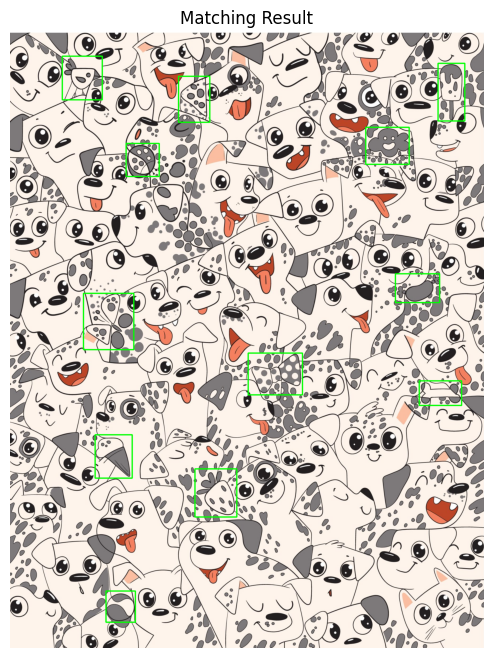

In [23]:
result_image = input_image.copy()
for (start, end) in best_positions:
    result_image = draw_rectangle(result_image, start, end, color=(0, 255, 0), thickness=3)
show_image(result_image, title='Matching Result')